In [306]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [307]:
def nonburst(N):
    spike_trains = np.empty(N, dtype="object")
    gen = np.random.default_rng()
    
    # Poisson 
    for i in range(int(N/2)):
        isis = gen.exponential(2, 200)
        isis = isis[isis > np.quantile(isis, 0.1)]      # discard bottom 10% of ISIs
        train = np.cumsum(isis)
        spike_trains[i] = train[train <= 300]
        
    # Gamma ISIs
    for i in range(int(N/2)):
        isis = gen.gamma(1, 2, 200)
        isis = isis[isis > np.quantile(isis, 0.1)]      # discard bottom 10% of ISIs
        train = np.cumsum(isis)
        spike_trains[i+int(N/2)] = train[train <= 300]
        
    return spike_trains

In [308]:
def nonstationary(N):
    spike_trains = np.empty(N, dtype="object")
    gen = np.random.default_rng()
    
    for i in range(N):
        # Generate homogeneous Poisson and discard bottom 10% of ISIs
        cand_isis = gen.exponential(0.5, 800)
        cand_isis = cand_isis[cand_isis > np.quantile(cand_isis, 0.1)]
        
        # convert homogeneous Poisson to inhomogeneous by thresholding uniform RV
        train = []
        t = 0
        ind = 0
        while True:
            t += cand_isis[ind]
            if t > 300:
                break
            ind += 1
            rate = 1 + t/300
            
            if gen.uniform(0,1) <= rate/2:
                train.append(t)
        spike_trains[i] = np.array(train)
        
    return spike_trains

In [309]:
def gen_pois_burst(rate, n, pos_min, pos_max):
    # pick burst times
    gen = np.random.default_rng()
    burst_times = np.sort(gen.uniform(0, 300, gen.poisson(rate*300)))
    num_bursts = burst_times.shape[0]
    
    # pick burst length and relative spike times
    burst_length = gen.poisson(n, num_bursts)
    burst_pos = np.array([np.sort(gen.uniform(pos_min, pos_max, l)) for l in burst_length], dtype="object")
    
    # calculate absolute spike times
    spike_times = np.array([burst_pos[i] + t for i,t in enumerate(burst_times)], dtype="object")
    spike_times = spike_times[burst_length > 2]
    burst_beg = np.array([spike_times[i][0] for i in range(spike_times.shape[0])])
    burst_end = np.array([spike_times[i][-1] for i in range(spike_times.shape[0])])

    # throw out overlapping bursts
    overlap = np.ones(burst_beg.shape[0], dtype="bool")
    overlap[:-1] = burst_beg[1:] - burst_end[:-1] < 0.5
    spike_times = spike_times[~overlap]
    burst_beg = burst_beg[~overlap]
    burst_end = burst_end[~overlap]

    # flatten and cutoff spike time array
    spike_times = np.concatenate(spike_times)
    spike_times = spike_times[spike_times <= 300]

    return spike_times, burst_beg.shape[0], burst_beg, burst_end

In [310]:
def gen_nonstat_burst(rate):
    # pick burst times
    gen = np.random.default_rng()
    burst_times = np.sort(gen.uniform(0, 300, gen.poisson(rate*300)))
    num_bursts = burst_times.shape[0]
    
    # pick burst length and relative spike times
    n = gen.uniform(5, 8, num_bursts)
    burst_length = np.array([gen.poisson(n[i]) for i in range(num_bursts)])
    pos_max = gen.uniform(0.3, 1, num_bursts)
    burst_pos = np.array([np.sort(gen.uniform(0, pos_max[i], burst_length[i])) for i in range(num_bursts)], dtype="object")
    
    # calculate absolute spike times
    spike_times = np.array([burst_pos[i] + t for i,t in enumerate(burst_times)], dtype="object")
    spike_times = spike_times[burst_length > 2]
    burst_beg = np.array([spike_times[i][0] for i in range(spike_times.shape[0])])
    burst_end = np.array([spike_times[i][-1] for i in range(spike_times.shape[0])])
    burst_length = burst_length[burst_length > 2]
    
    # throw out bursts with < 5 Hz intraburst firing rate
    fr = burst_length/(burst_end - burst_beg) > 5
    spike_times = spike_times[fr]
    burst_beg = burst_beg[fr]
    burst_end = burst_end[fr]

    # throw out overlapping bursts
    overlap = np.ones(burst_beg.shape[0], dtype="bool")
    overlap[:-1] = burst_beg[1:] - burst_end[:-1] < 0.5
    spike_times = spike_times[~overlap]
    burst_beg = burst_beg[~overlap]
    burst_end = burst_end[~overlap]

    # flatten and cutoff spike time array
    spike_times = np.concatenate(spike_times)
    spike_times = spike_times[spike_times <= 300]

    return spike_times, burst_beg.shape[0]

In [311]:
def short_burst(N):
    spike_trains = np.empty(N, dtype="object")
    num_bursts = np.zeros(N)
    for i in range(N):
        spike_trains[i], num_bursts[i], _, _ = gen_pois_burst(0.2, 5, 0, 0.3)
        
    return spike_trains, num_bursts

In [326]:
def long_burst(N):
    spike_trains = np.empty(N, dtype="object")
    num_bursts = np.zeros(N)
    for i in range(N):
        spike_trains[i], num_bursts[i], _, _ = gen_pois_burst(0.1, 18, 0, 3)
        
    return spike_trains, num_bursts

In [313]:
def high_freq(N):
    spike_trains = np.empty(N, dtype="object")
    num_bursts = np.zeros(N)
    for i in range(N):
        spike_trains[i], num_bursts[i], _, _ = gen_pois_burst(1, 10, 0, 0.5)
        
    return spike_trains, num_bursts

In [314]:
def nonstationary_burst(N):
    spike_trains = np.empty(N, dtype="object")
    num_bursts = np.zeros(N)
    for i in range(N):
        spike_trains[i], num_bursts[i] = gen_nonstat_burst(0.3)
        
    return spike_trains, num_bursts

In [315]:
def noisy_train(N):
    spike_trains = np.empty(N, dtype="object")
    labels = np.empty(N, dtype="object")
    num_bursts = np.zeros(N)
    gen = np.random.default_rng()
    for i in range(N):
        spike_trains[i], num_bursts[i], beg, end = gen_pois_burst(0.5, 8, 0, 0.8)
        
        # generate gamma distributed noise
        isis = gen.gamma(1, 2, 200)
        isis = isis[isis > np.quantile(isis, 0.1)]      # discard bottom 10% of ISIs
        noise_times = np.cumsum(isis)
        noise_times = noise_times[noise_times <= 300]
        
        
        # discard noise too close to bursts
        keep = np.zeros(noise_times.shape[0], dtype="bool")
        for j in range(keep.shape[0]):
            keep[j] = (np.abs(beg - noise_times[j]) > 0.5).all() & (np.abs(noise_times[j] - end) > 0.5).all()
        noise_times = noise_times[keep]
        
        # combine noise with bursts
        inds = np.argsort(np.concatenate((spike_trains[i], noise_times)))
        labels[i] = np.concatenate((np.ones(spike_trains[i].shape[0]),np.zeros(noise_times.shape[0])))[inds]
        spike_trains[i] = np.concatenate((spike_trains[i], noise_times))[inds]
                                                  
    return spike_trains, labels, num_bursts

In [327]:
d5 = nonburst(100)
d6 = nonstationary(100)
d7, d7nb = short_burst(100)
d8, d8nb = nonstationary_burst(100)
d9, d9nb = long_burst(100)
d10, d10nb = high_freq(100)
d11, d11_lab, d11nb = noisy_train(100)

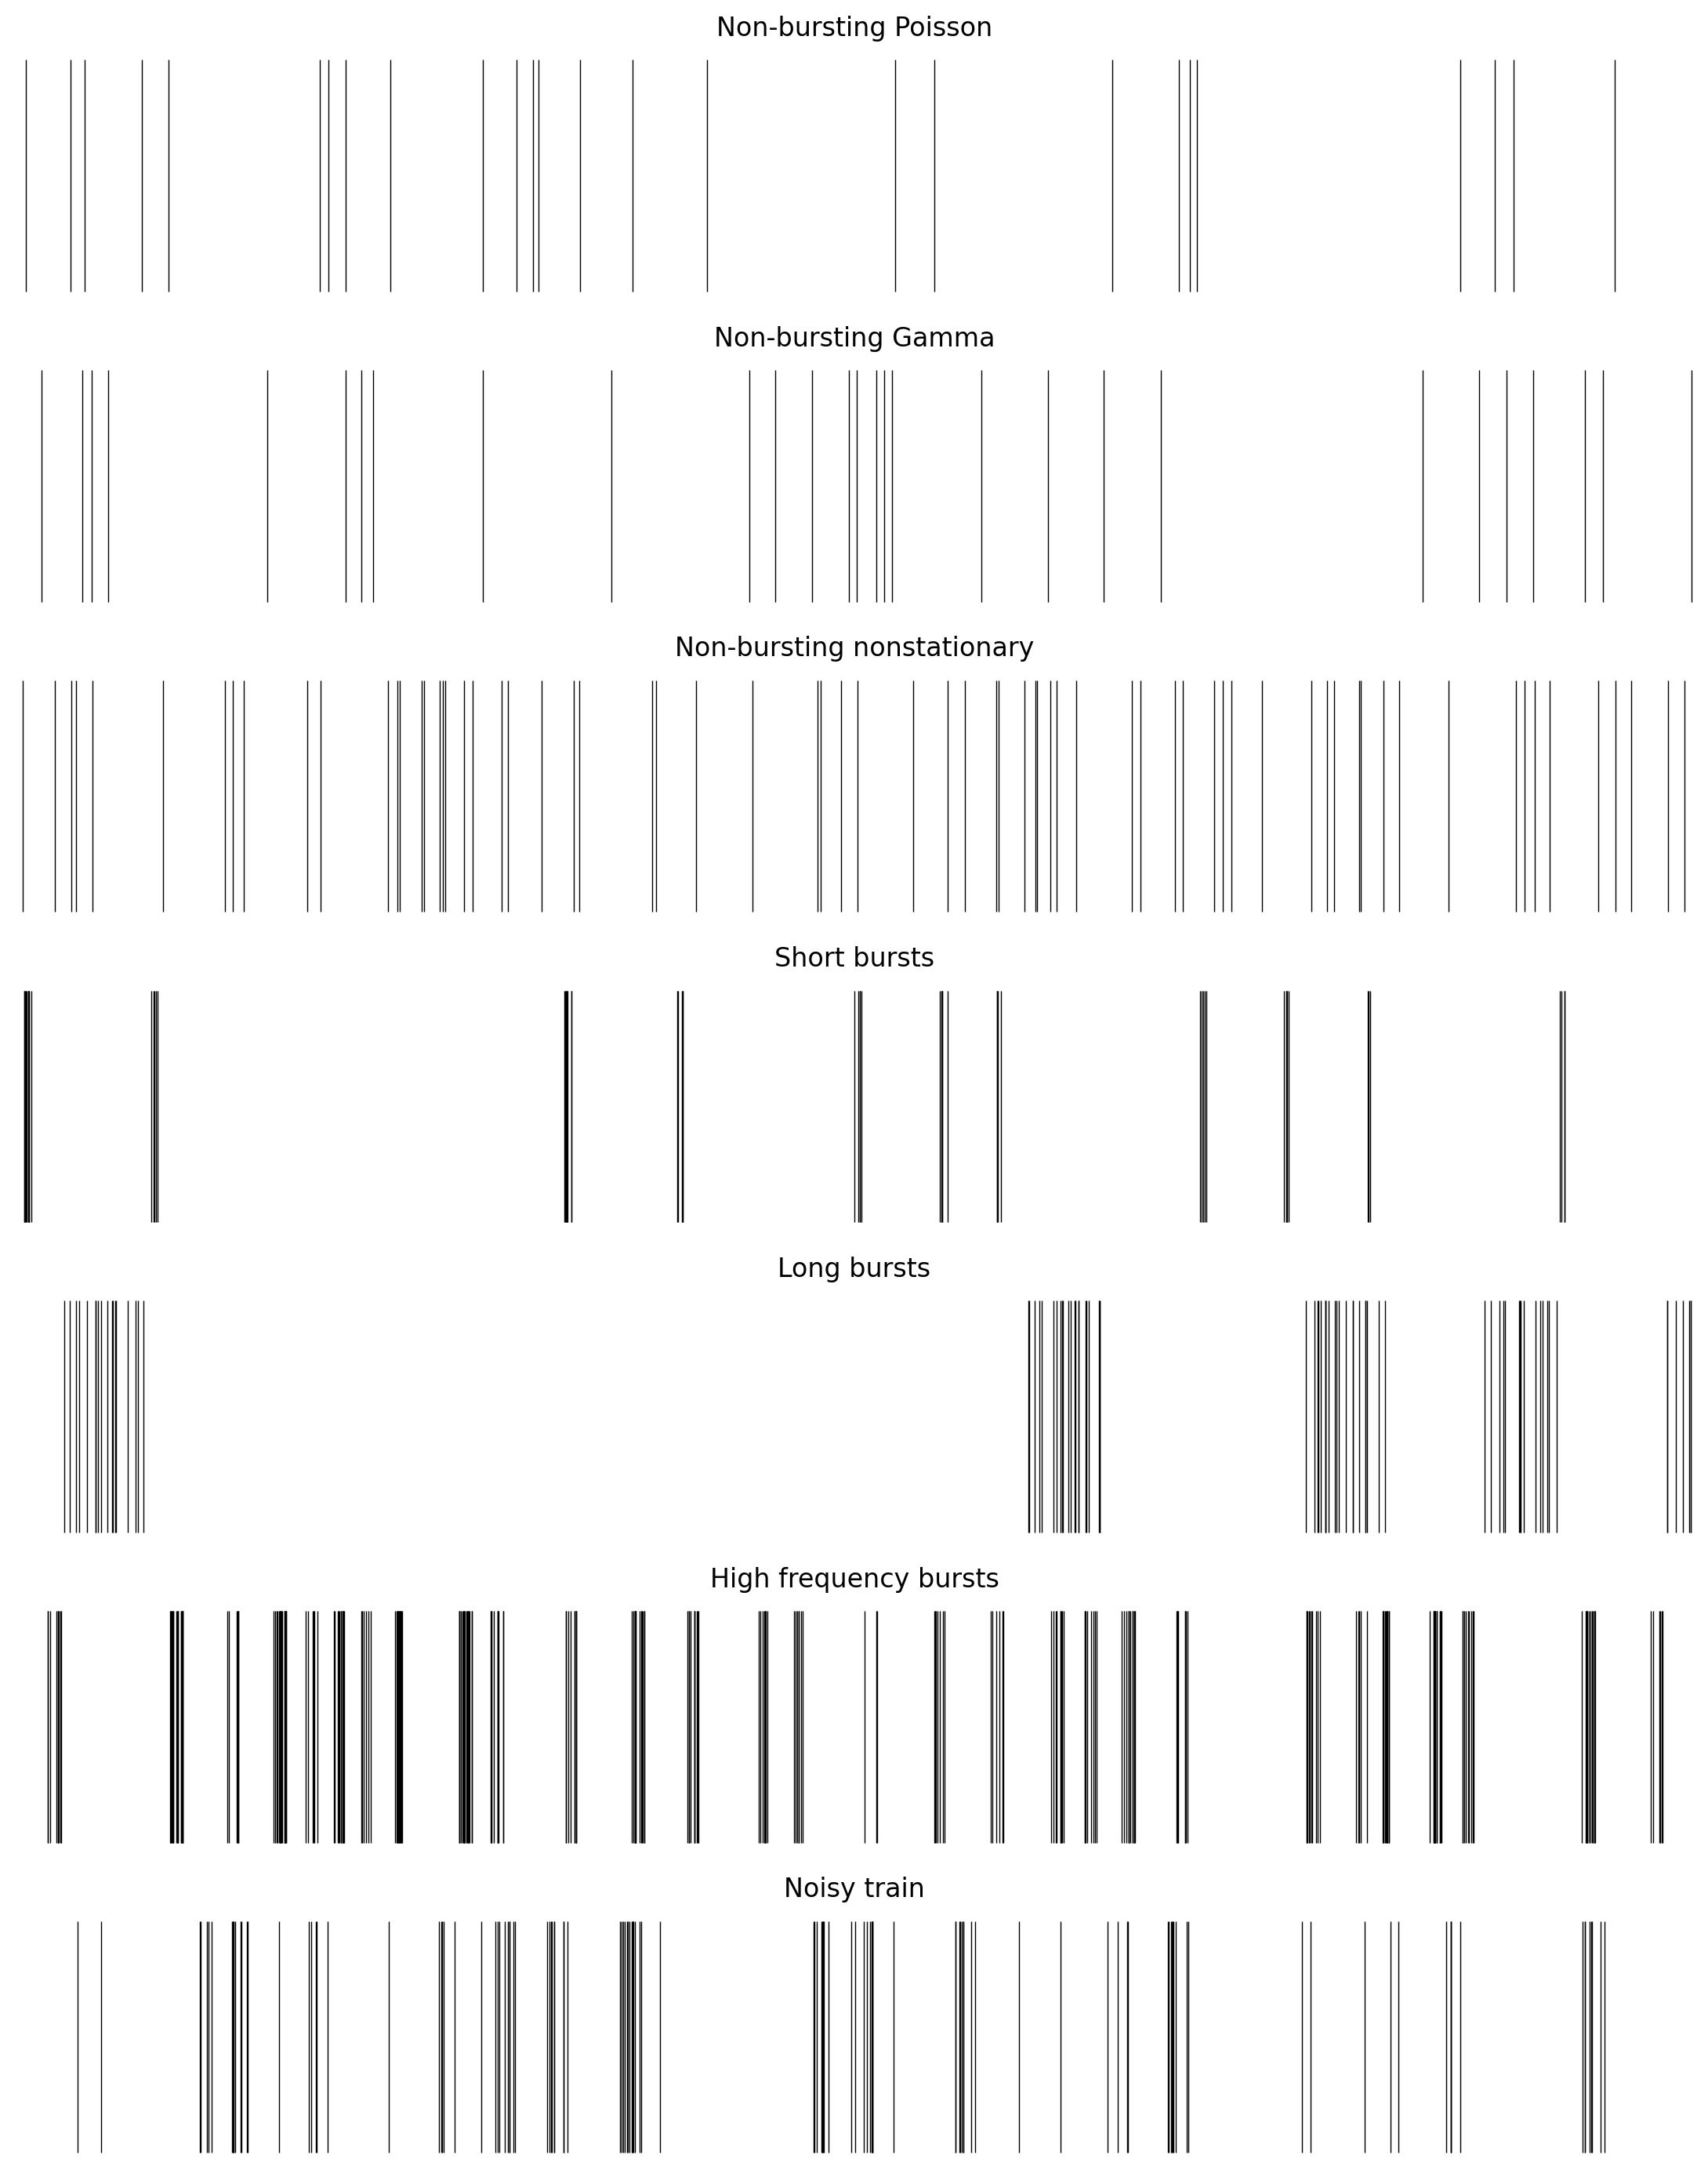

In [336]:
plt.figure(figsize=(11,14))
plt.subplot(7,1,1)
marker, stem, base = plt.stem(d5[35], np.ones(d5[35].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Non-bursting Poisson");

plt.subplot(7,1,2)
marker, stem, base = plt.stem(d5[75], np.ones(d5[75].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Non-bursting Gamma");

plt.subplot(7,1,3)
marker, stem, base = plt.stem(d6[12], np.ones(d6[12].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Non-bursting nonstationary");

plt.subplot(7,1,4)
marker, stem, base = plt.stem(d7[65], np.ones(d7[65].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Short bursts");

plt.subplot(7,1,5)
marker, stem, base = plt.stem(d9[22], np.ones(d9[22].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Long bursts");

plt.subplot(7,1,6)
marker, stem, base = plt.stem(d10[25], np.ones(d10[25].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("High frequency bursts");

plt.subplot(7,1,7)
marker, stem, base = plt.stem(d11[60], np.ones(d11[60].shape[0]), markerfmt=" ", linefmt="k"); plt.xlim([0, 60]);
plt.setp(stem, 'linewidth', .5)
plt.setp(base, 'linewidth', 0); plt.axis('off');
plt.title("Noisy train");

plt.tight_layout()
plt.savefig("../figures/poster/sim_trains.svg", transparent=True)

In [328]:
np.save("../data/bursting/d5.npy", d5, allow_pickle=True)
np.save("../data/bursting/d6.npy", d6, allow_pickle=True)
np.save("../data/bursting/d7.npy", d7, allow_pickle=True)
np.save("../data/bursting/d7nb.npy", d7nb, allow_pickle=True)
np.save("../data/bursting/d8.npy", d8, allow_pickle=True)
np.save("../data/bursting/d8nb.npy", d8nb, allow_pickle=True)
np.save("../data/bursting/d9.npy", d9, allow_pickle=True)
np.save("../data/bursting/d9nb.npy", d9nb, allow_pickle=True)
np.save("../data/bursting/d10.npy", d10, allow_pickle=True)
np.save("../data/bursting/d10nb.npy", d10nb, allow_pickle=True)
np.save("../data/bursting/d11.npy", d11, allow_pickle=True)
np.save("../data/bursting/d11nb.npy", d11nb, allow_pickle=True)
np.save("../data/bursting/d11_lab.npy", d11_lab, allow_pickle=True)